In [1]:
# import data
from pylab import *
from sklearn.utils import shuffle
# from sklearn import preprocessing
import matplotlib.pyplot as plt
from scipy import stats
import sys
import pickle

sys.path.insert(0, '../src')

%matplotlib inline
import h5py

In [2]:
from numpy import *
import tensorflow as tf
import random as rn

import os
os.environ['PYTHONHASHSEED'] = '0'

np.random.seed(42)

rn.seed(12345)

# session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K
# tf.set_random_seed(12345)
tf.random.set_seed(12345)

sees = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
# K.set_session(sees)
tf.compat.v1.keras.backend.set_session(sees)

Using TensorFlow backend.


In [3]:
# cnn model
import keras
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Flatten, Dropout, Activation
from keras.layers.convolutional import Conv1D, ZeroPadding1D, MaxPooling1D
from keras.utils import to_categorical
from keras.layers.core import Reshape 
from keras import activations

In [4]:
def build_model(trainX, trainy):
    keras.backend.clear_session()
    
    n_offset = trainX.shape[1]
    n_outputs = trainy.shape[1]
    print (n_outputs)
    n_features = 1
    
    model = Sequential()
#     model.add(Reshape((trainX.shape[1], 1), input_shape=(trainX.shape[1], )))
    
#     1st
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', name='conv_1', input_shape=(n_offset,n_features)))
    model.add(MaxPooling1D(pool_size=2))  
#     model.add(Dropout(0.25))
              
#     2nd
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same',name='conv_2'))
    model.add(MaxPooling1D(pool_size=2))
#     model.add(Dropout(0.25))

#     3nd
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same',name='conv_3'))
    model.add(MaxPooling1D(pool_size=2))
#     model.add(Dropout(0.25))

#     4th
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same',name='conv_4'))
    model.add(MaxPooling1D(pool_size=2))
#     model.add(Dropout(0.25))
              
    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu', name='dense'))
    
    model.add(Dense(n_outputs, activation='softmax', name='output'))   
    sgd = keras.optimizers.SGD(lr=0.01)
    model.compile(loss = "categorical_crossentropy", metrics=['accuracy'], optimizer = sgd)
    
#     model.compile(loss = "categorical_crossentropy", metrics=['accuracy'], optimizer = keras.optimizers.sgd())
           
    model.summary()
    return model

In [5]:
import pickle

def smooth_curve(points, factor=0.8):
    smoothed = []
    for point in points:
        if smoothed:
            previous = smoothed[-1]
            smoothed.append(previous * factor + point * (1 - factor))
        else:
            smoothed.append(point)
    return smoothed

def plot_compare(history, steps=-1):
    if steps < 0:
        steps = len(history.history['accuracy'])
    mse = smooth_curve(history.history['accuracy'][:steps])
    val_mse = smooth_curve(history.history['val_accuracy'][:steps])
    loss = smooth_curve(history.history['loss'][:steps])
    val_loss = smooth_curve(history.history['val_loss'][:steps])
    
    plt.figure(figsize=(6, 4))
    plt.plot(loss, c='#0c7cba', label='Train Loss')
    plt.plot(val_loss, c='#0f9d58', label='Val Loss')
    plt.xticks(range(0, len(loss), 5))
    plt.xlim(0, len(loss))
    plt.title('Train Loss: %.3f, Val Loss: %.3f' % (loss[-1], val_loss[-1]), fontsize=12)
    plt.legend()
    
    plt.figure(figsize=(6, 4))
    plt.plot(mse, c='#0c7cba', label='Train accuracy')
    plt.plot(val_mse, c='#0f9d58', label='Val accuracy')
    plt.xticks(range(0, len(mse), 5))
    plt.xlim(0, len(mse))
    plt.title('Train accuracy: %.3f, Val accuracy: %.3f' % (mse[-1], val_mse[-1]), fontsize=12)
    plt.legend()

In [6]:
def save_history(history, fn):
    with open(fn, 'wb') as fw:
        pickle.dump(history.history, fw, protocol=2)

def load_history(fn):
    class Temp():
        pass
    history = Temp()
    with open(fn, 'rb') as fr:
        history.history = pickle.load(fr)
    return history

In [7]:
def evaluate_model(X, y):
    verbose, epochs, batch_size = 1, 200, 64
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
#     patience: Number of epochs with no improvement after which training will be stopped.
    model = build_model(X, y)
    history = model.fit(X, y, validation_split=0.2,
                    epochs=epochs, batch_size=batch_size, verbose=verbose,
                       callbacks=[early_stop]) 

    model.save_weights('model_weights_20210201_64_4_uneven_2.h5')
        
    save_history(history, 'history_20210201_64_4_uneven_2.bin')
#     history = load_history('history.bin')
#     plot_compare(history, steps=50)  
    return model

In [8]:
# summarize scores
def summarize_results(scores):
    # summarize mean and standard deviation
    for i in range(len(scores)):
        m, s = mean(scores[i]), std(scores[i])
        print('Param=%d: %.3f%% (+/-%.3f)' % (params[i], m, s))
        # boxplot of scores
    pyplot.boxplot(scores, labels=params)
    pyplot.savefig('exp_cnn_filters.png')

# load training data

In [9]:

filepath = '/Users/cbie1/OneDrive - Johns Hopkins/JHU/CEST/Machine_Learning_BreastTumor/double_tumor/material_paper/20210104/simulation_matlab/'

file=h5py.File(filepath + 'training_simData_2.0uT_20210201.h5','r')
simulationMatrix2pt = file['simData'][:]
simulationMatrix2pt = simulationMatrix2pt
trainingDataIndex2pt = file['Index'][:]
trainingDataIndex2pt.shape

file=h5py.File(filepath + 'training_simData_1.0uT_20210201.h5','r')
simulationMatrix1pt = file['simData'][:]
simulationMatrix1pt = simulationMatrix1pt
trainingDataIndex1pt = file['Index'][:]
trainingDataIndex1pt.shape

file=h5py.File(filepath + 'training_simData_0.5uT_20210201.h5','r')
simulationMatrix0pt5 = file['simData'][:]
simulationMatrix0pt5 = simulationMatrix0pt5
trainingDataIndex0pt5 = file['Index'][:]
trainingDataIndex0pt5.shape

(300000,)

In [10]:
cestFreq = np.linspace(-6,6,81)
cestFreq[46]

0.8999999999999995

In [12]:
cestFreq = np.linspace(-6,6,81)

ind = r_[0:35,46:81]

cestFreq = cestFreq[ind]
simulationMatrix2pt =  simulationMatrix2pt[:,ind]
simulationMatrix1pt =  simulationMatrix1pt[:,ind]
simulationMatrix0pt5 =  simulationMatrix0pt5[:,ind]
simulationMatrix2pt.shape

(300000, 70)

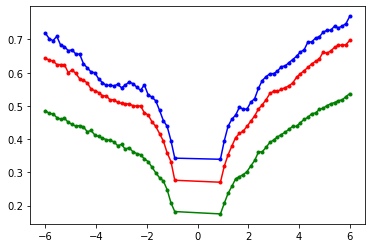

In [13]:
plot(cestFreq,simulationMatrix2pt[20],'b.-')
plot(cestFreq,simulationMatrix2pt[100000],'r.-')
plot(cestFreq,simulationMatrix2pt[200000],'g.-')

# model0 MCF-7 & MDA-231 & normal PCA

In [14]:
trainingDataIndex0 = trainingDataIndex2pt

In [15]:
freq_Zspec0 = np.where( (cestFreq >=-6.1) * (cestFreq <= 6.1))
# freq_Zspec0 = np.hstack((np.where( (cestFreq <= -.5) * (cestFreq >= -6.1) ),
#                         np.where( (cestFreq >= .5) * (cestFreq <= 6.1) )))[0]


trainingMatrix0 = []
for ii in range(simulationMatrix2pt.shape[0]):
    trainingFeatures = []
    trainingFeatures += list(squeeze(simulationMatrix2pt[ii,freq_Zspec0]))
#     trainingFeatures += list(squeeze(simulationMatrix1pt[ii,freq_Zspec0]))
#     trainingFeatures += list(squeeze(simulationMatrix0pt5[ii,freq_Zspec0]))
    trainingMatrix0.append(trainingFeatures)
trainingDataNew0 = array(trainingMatrix0)

In [16]:
trainingDataIndex0 = keras.utils.to_categorical(trainingDataIndex2pt, 3)
# trainingDataIndex = reshape(trainingDataIndex2pt, (len(trainingDataIndex2pt),1))

In [17]:
trainX0 = trainingDataNew0
trainX0 = reshape(trainX0,(trainX0.shape[0], trainX0.shape[1], 1))
trainy0 = trainingDataIndex0

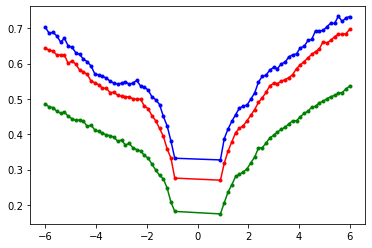

In [18]:
plot(cestFreq,trainX0[10],'b.-')
plot(cestFreq,trainX0[100000],'r.-')
plot(cestFreq,trainX0[200000],'g.-')

In [19]:
   # test data
testX, testy = shuffle(trainX0, trainy0, random_state=42)

In [21]:
# # CNN training
# import time

# start_time = time.clock()
# trainXnew = testX
# trainynew = testy
# model = evaluate_model(trainXnew, trainynew)

# print (time.clock() - start_time, "seconds")

3

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv1D)              (None, 70, 64)            256       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 35, 64)            0         
_________________________________________________________________
conv_2 (Conv1D)              (None, 35, 64)            12352     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 17, 64)            0         
_________________________________________________________________
conv_3 (Conv1D)              (None, 17, 64)            12352     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 8, 64)             0         
_________________________________________________________________
conv_4 (Conv1D)              (None, 8, 64)         

240000/240000 [==============================] - 69s 287us/step - loss: 2.5212e-05 - accuracy: 1.0000 - val_loss: 5.1192e-07 - val_accuracy: 1.0000
Epoch 38/200
240000/240000 [==============================] - 65s 272us/step - loss: 2.9519e-05 - accuracy: 1.0000 - val_loss: 5.7915e-07 - val_accuracy: 1.0000
Epoch 39/200
240000/240000 [==============================] - 69s 289us/step - loss: 2.5350e-05 - accuracy: 1.0000 - val_loss: 4.6462e-07 - val_accuracy: 1.0000
Epoch 40/200
240000/240000 [==============================] - 66s 275us/step - loss: 3.6065e-05 - accuracy: 1.0000 - val_loss: 5.8322e-07 - val_accuracy: 1.0000
Epoch 41/200
240000/240000 [==============================] - 67s 281us/step - loss: 2.6836e-05 - accuracy: 1.0000 - val_loss: 4.7419e-07 - val_accuracy: 1.0000
Epoch 42/200
240000/240000 [==============================] - 65s 272us/step - loss: 2.2809e-05 - accuracy: 1.0000 - val_loss: 3.8251e-07 - val_accuracy: 1.0000
Epoch 43/200
240000/240000 [===================

Epoch 88/200
240000/240000 [==============================] - 68s 282us/step - loss: 1.1572e-05 - accuracy: 1.0000 - val_loss: 9.5943e-08 - val_accuracy: 1.0000
Epoch 89/200
240000/240000 [==============================] - 66s 273us/step - loss: 1.1124e-05 - accuracy: 1.0000 - val_loss: 1.2293e-07 - val_accuracy: 1.0000
Epoch 90/200
240000/240000 [==============================] - 67s 281us/step - loss: 1.0295e-05 - accuracy: 1.0000 - val_loss: 6.8062e-08 - val_accuracy: 1.0000
Epoch 91/200
240000/240000 [==============================] - 66s 277us/step - loss: 9.4546e-06 - accuracy: 1.0000 - val_loss: 6.0999e-08 - val_accuracy: 1.0000
Epoch 92/200
240000/240000 [==============================] - 66s 275us/step - loss: 9.2776e-06 - accuracy: 1.0000 - val_loss: 2.2959e-07 - val_accuracy: 1.0000
Epoch 93/200
240000/240000 [==============================] - 66s 275us/step - loss: 8.6316e-06 - accuracy: 1.0000 - val_loss: 6.2123e-08 - val_accuracy: 1.0000
Epoch 94/200
240000/240000 [======

In [20]:
trainXnew = testX
trainynew = testy
model = build_model(trainXnew, trainynew)
model.load_weights("model_weights_20210201_64_4_uneven_2.h5")

3
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv1D)              (None, 70, 64)            256       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 35, 64)            0         
_________________________________________________________________
conv_2 (Conv1D)              (None, 35, 64)            12352     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 17, 64)            0         
_________________________________________________________________
conv_3 (Conv1D)              (None, 17, 64)            12352     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 8, 64)             0         
_________________________________________________________________
conv_4 (Conv1D)              (None, 8, 64)          

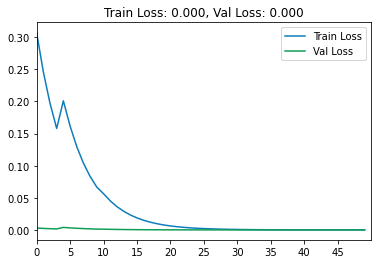

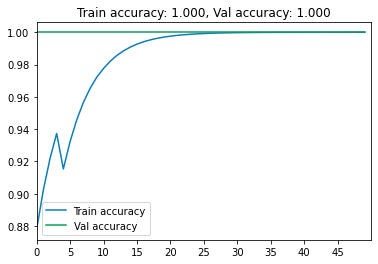

In [21]:
history = load_history('history_20210201_64_4_uneven_2.bin')
plot_compare(history, steps=50)

In [29]:
# from keras.utils.vis_utils import plot_model
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [30]:
def my_custom_loss_func(y_true, y_pred):
    
    y_true_new = zeros(y_true.shape[0])
    y_pred_new = zeros(y_pred.shape[0])

    for ii in range(y_true.shape[0]):
        y_true_new[ii] = numpy.argmax(y_true[ii])
        y_pred_new[ii] = numpy.argmax(y_pred[ii])
    
    score = 0
    for ii in range(y_true.shape[0]):
        if y_pred_new[ii] == y_true_new[ii]:
            score=score+1
    score = score / y_true.shape[0]
    return score

In [31]:
# read data
import numpy
#mouse3 -----------------------------
# # 2mm
mouse = 'M3_2'
path2 = '/Volumes/CX/JHU/Machine_Learning_BreastTumor/results/20210104/old_mice/M3-2/'
sep_2pt = np.loadtxt(path2 + 'M3_2whole_sep_2pt_denoising_filter.csv', delimiter = ',')
Index = np.loadtxt(path2 + 'M3_2whole_sep_2pt_denoising_filter_index.csv', delimiter = ',')

cestFreq = np.linspace(-6,6,81)
sep_2pt = sep_2pt[:,ind]

cestFreq = cestFreq[ind]

# reshape test_invivo
expDataMatrix0_2pt_use = sep_2pt

combinedExpData0 = []
for ii in range(expDataMatrix0_2pt_use.shape[0]):
    combinedExpDatai = []
    combinedExpDatai+=list(squeeze(expDataMatrix0_2pt_use[ii,freq_Zspec0]))
#     combinedExpDatai+=list(squeeze(expDataMatrix0_1pt_use[ii,freq_Zspec0]))
#     combinedExpDatai+=list(squeeze(expDataMatrix0_0pt5_use[ii,freq_Zspec0]))
    combinedExpData0.append(combinedExpDatai)
combinedExpData0 = array(combinedExpData0)
test_invivo = combinedExpData0

test_invivo = reshape(test_invivo, (test_invivo.shape[0], test_invivo.shape[1],1))
test_Label = keras.utils.to_categorical(Index, 3)

all_preds = model.predict(test_invivo) 
Invivo_pred_new = zeros(all_preds.shape[0])

for ii in range(all_preds.shape[0]):
    Invivo_pred_new[ii] = numpy.argmax(all_preds[ii])

from sklearn import metrics
from sklearn.metrics import f1_score
print('mean_squraed_error: %f' % (metrics.mean_squared_error(Invivo_pred_new, Index)))
print('accuracy_score: %.3f' % (metrics.accuracy_score(Invivo_pred_new, Index, normalize=True, sample_weight=None)))
print('accuracy_score: %.3f' % (my_custom_loss_func(all_preds, test_Label)))


# average_precision_score

mean_squraed_error: 0.360345
accuracy_score: 0.759
accuracy_score: 0.759


In [32]:
# =============================================
# Saliency Maps code
# =============================================
from vis.visualization import visualize_saliency, visualize_activation
from vis.utils import utils
import matplotlib.pyplot as plt
import numpy as np

layer_index = utils.find_layer_idx(model, 'output')
model.layers[layer_index].activation = activations.linear
model_new = utils.apply_modifications(model)  


help(utils.apply_modifications)# =============================================
# Saliency Maps code
# =============================================
from vis.visualization import visualize_saliency, visualize_activation
from vis.utils import utils
import matplotlib.pyplot as plt
import numpy as np

layer_index = utils.find_layer_idx(model, 'output')
model.layers[layer_index].activation = activations.linear
model_new = utils.apply_modifications(model)  


help(utils.apply_modifications)

Help on function apply_modifications in module vis.utils.utils:

apply_modifications(model, custom_objects=None)
    Applies modifications to the model layers to create a new Graph. For example, simply changing
    `model.layers[idx].activation = new activation` does not change the graph. The entire graph needs to be updated
    with modified inbound and outbound tensors because of change in layer building function.
    
    Args:
        model: The `keras.models.Model` instance.
    
    Returns:
        The modified model with changes applied. Does not mutate the original `model`.

Help on function apply_modifications in module vis.utils.utils:

apply_modifications(model, custom_objects=None)
    Applies modifications to the model layers to create a new Graph. For example, simply changing
    `model.layers[idx].activation = new activation` does not change the graph. The entire graph needs to be updated
    with modified inbound and outbound tensors because of change in layer building

In [33]:
inds_0=where((Index==0))[0][36:40]
inds_1=where((Index==1))[0][9:13]
inds_2=where((Index==2))[0][70:74]

# inds_0=where((Index==0))[0][36:40]
# inds_1=where((Index==1))[0][10:14]
# inds_2=where((Index==2))[0][10:14]

In [34]:
Invivo_pred_new[inds_2]

array([2., 2., 2., 2.])

In [35]:
from vis.visualization import visualize_saliency
class_idx = 0
test = zeros((12,test_invivo.shape[1],test_invivo.shape[2]))
test[:4] = test_invivo[inds_0]
test[4:8] = test_invivo[inds_1]
test[8:] = test_invivo[inds_2]
grad_top = zeros((test.shape[0],test.shape[1]))

for ii in range(test.shape[0]):
    test_use = test[ii]
    input_image = test_use[np.newaxis,...]
    grad_top[ii] = visualize_saliency(model_new,
                               layer_index,
                               filter_indices = class_idx,
                               seed_input     = input_image)
    

Text(-0.5,0.5,'True label')

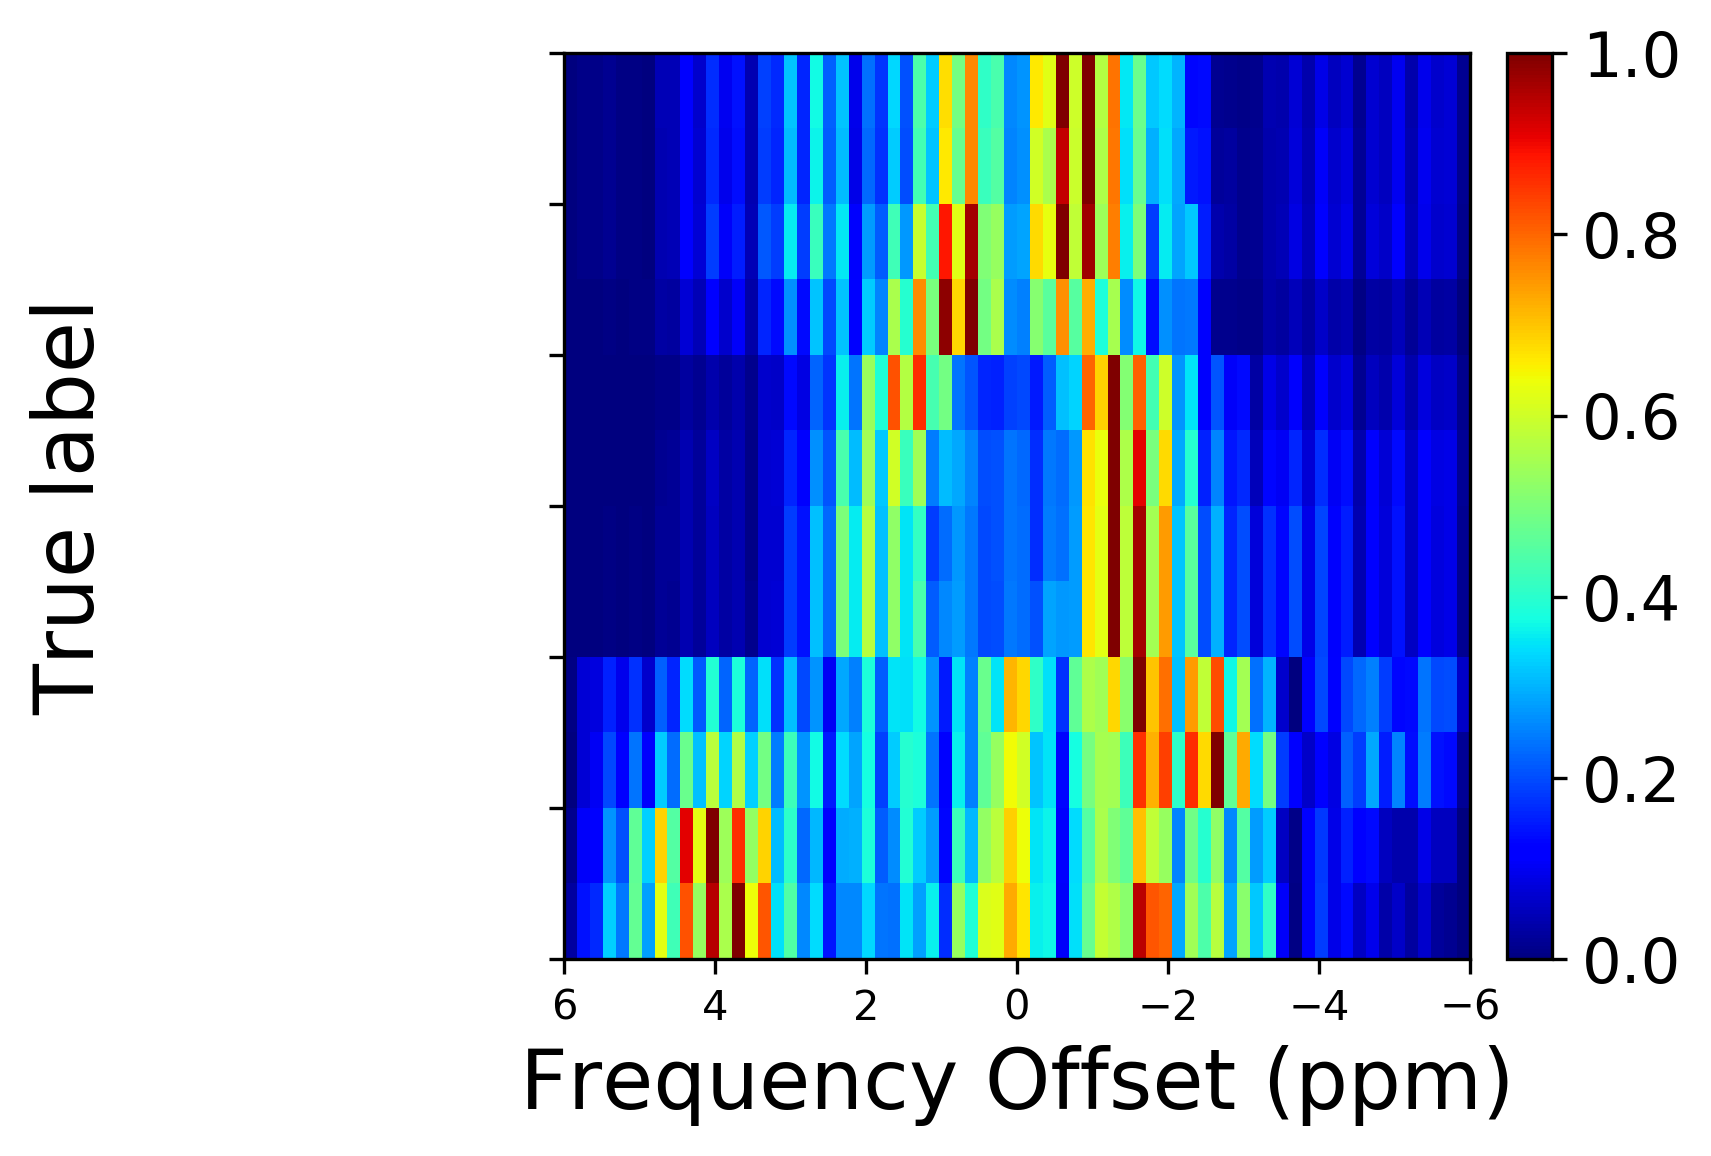

In [36]:
fig, ax = plt.subplots(1,1,figsize = (8,4),dpi=300)
# title('Saliency map', fontsize=25)
grad_top_filp = zeros(grad_top.shape)
grad_top_filp = fliplr(grad_top)

img = ax.imshow(grad_top_filp,extent=[6,-6,0,12], cmap='jet')
img.set_clim(0, 1)

# y_label_list = ["","Muscle","","MCF-7","","MDA-MB-231",]
y_label_list = ["","","","","","",]
x_label_list = flipud(cestFreq)
ax.set_yticklabels(y_label_list,fontsize=15)
# plt.setp(ax.get_yticklabels(), rotation=60, ha="right",
#          rotation_mode="anchor")
plt.rcParams['xtick.labelsize']=12

# fig.colorbar(img)
cbar = fig.colorbar(img,  pad=0.02,shrink=1,ticks = [0,0.2,0.4,0.6,0.8,1.0])

# ax.set_xticklabels([6, 4, 2, 0, -2, -4, -6])
cbar.ax.tick_params(labelsize=15)

ax.set_xlabel('Frequency Offset (ppm)', fontsize=20)
# ax.set_ylabel('True label', fontsize=20)
ax.text(-0.5, 0.5, 'True label', rotation=90, 
            verticalalignment='center', horizontalalignment='right', 
            transform=ax.transAxes, fontsize=20)

# model2: MDA-231 & normal

In [22]:
simulationMatrix2pt_use2 = []
simulationMatrix1pt_use2 = []
simulationMatrix0pt5_use2 = []
index = []
for ii in range(len(simulationMatrix2pt)):
    if trainingDataIndex2pt[ii] != 2:
        simulationMatrix2pt_use2.append(simulationMatrix2pt[ii])
        simulationMatrix1pt_use2.append(simulationMatrix1pt[ii])
        simulationMatrix0pt5_use2.append(simulationMatrix0pt5[ii])
        index.append(trainingDataIndex2pt[ii])
simulationMatrix2pt_use2 = array(simulationMatrix2pt_use2)
simulationMatrix1pt_use2 = array(simulationMatrix1pt_use2)
simulationMatrix0pt5_use2 = array(simulationMatrix0pt5_use2)

index = array(index)
trainingDataIndex2 = index


In [24]:
# freq_Zspec2 = np.hstack((np.where( (cestFreq >= -6) * (cestFreq <= -2) ),
#                          np.where( (cestFreq <= 4) * (cestFreq >= 3))))[0]

# freq_Zspec2 = np.hstack((np.where( (cestFreq >= -3) * (cestFreq <= -1) ),
#                          np.where( (cestFreq <= 4) * (cestFreq >= 2))))[0]

freq_Zspec2 = where ((cestFreq<=-0.5)*(cestFreq>=-3))
# freq_Zspec2 = find ((cestFreq<=3)*(cestFreq>=0.5))
# freq_Zspec2 = np.hstack((np.where( (cestFreq >= -3) * (cestFreq <= -0.5) ),
#                          np.where( (cestFreq <= 3) * (cestFreq >= 0.5))))[0]


trainingMatrix2 = []
for ii in range(simulationMatrix2pt_use2.shape[0]):
    trainingFeatures = []
    trainingFeatures += list(squeeze(simulationMatrix2pt_use2[ii, freq_Zspec2]))
#     trainingFeatures += list(squeeze(simulationMatrix1pt_use2[ii, freq_Zspec2]))
#     trainingFeatures += list(squeeze(simulationMatrix0pt5_use2[ii, freq_Zspec2]))
    trainingMatrix2.append(trainingFeatures)
trainingDataNew2 = array(trainingMatrix2)

In [25]:
trainX2 = trainingDataNew2
trainy2 = trainingDataIndex2
trainX2.shape

(200000, 15)

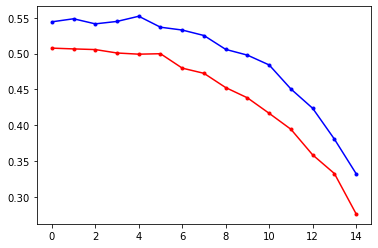

In [26]:
plot(trainX2[10],'b.-', label = 'MDA231')
plot(trainX2[100000],'r.-', label='MCF-7')

# train model

In [27]:
import time
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

In [28]:
start_time = time.clock()
from sklearn.neighbors import KNeighborsClassifier

clf2 = KNeighborsClassifier(n_neighbors=200)
clf2.fit(trainX2,trainy2)

# KFold Cross Validation approach
kf = KFold(n_splits=10,shuffle=False)
kf.split(trainX2)    
     
accuracy_model = []
trainy2 = squeeze(trainy2) 
for train_index, test_index in kf.split(trainX2):
    X_train, X_test = trainX2[train_index], trainX2[test_index]
    y_train, y_test = trainy2[train_index], trainy2[test_index]
    clf2 = clf2.fit(X_train, y_train)
  
print (time.clock() - start_time, "seconds")

4.438926000000002 seconds


In [28]:
pkl_filename = "model2_full_2pt_uneven.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(clf2, file)

# # # # Load from file
# with open(pkl_filename, 'rb') as file:
#     clf2 = pickle.load(file)

# test on in vivo data

In [43]:
# read data
import numpy
#mouse3 -----------------------------
# # 2mm
mouse = 'M1_3'
path2 = '/Volumes/CX/JHU/Machine_Learning_BreastTumor/results/20210104/old_mice/M1-3/'
sep_2pt = np.loadtxt(path2 + 'M1_3whole_sep_2pt_denoising_filter.csv', delimiter = ',')
# whole_2pt = np.loadtxt(path2 + 'M1_3whole_test_2pt_denoising_filter.csv', delimiter = ',')
Index = np.loadtxt(path2 + 'M1_3whole_sep_2pt_denoising_filter_index.csv', delimiter = ',')

sep_1pt = np.loadtxt(path2 + 'M1_3whole_sep_1pt_denoising_filter.csv', delimiter = ',')
# whole_1pt = np.loadtxt(path2 + 'M1_3whole_test_1pt_denoising_filter.csv', delimiter = ',')

sep_0pt5 = np.loadtxt(path2 + 'M1_3whole_sep_0pt5_denoising_filter.csv', delimiter = ',')
# whole_0pt5 = np.loadtxt(path2 + 'M1_3whole_test_0pt5_denoising_filter.csv', delimiter = ',')


cestFreq = np.linspace(-6,6,81)

In [61]:
# read data
import numpy
#mouse3 -----------------------------
# # 2mm
mouse = 'M2'
path2 = '/Volumes/CX/JHU/Machine_Learning_BreastTumor/results/20210104/old_mice/M2/'
sep_2pt = np.loadtxt(path2 + 'M2whole_sep_2pt_denoising_filter.csv', delimiter = ',')
# whole_2pt = np.loadtxt(path2 + 'M2whole_test_2pt_denoising_filter.csv', delimiter = ',')
Index = np.loadtxt(path2 + 'M2whole_sep_2pt_denoising_filter_index.csv', delimiter = ',')

sep_1pt = np.loadtxt(path2 + 'M2whole_sep_1pt_denoising_filter.csv', delimiter = ',')
# whole_1pt = np.loadtxt(path2 + 'M2whole_test_1pt_denoising_filter.csv', delimiter = ',')

sep_0pt5 = np.loadtxt(path2 + 'M2whole_sep_0pt5_denoising_filter.csv', delimiter = ',')
# whole_0pt5 = np.loadtxt(path2 + 'M2whole_test_0pt5_denoising_filter.csv', delimiter = ',')


cestFreq = np.linspace(-6,6,81)

In [79]:
# read data
import numpy
#mouse3 -----------------------------
# # 2mm
mouse = 'M3'
path2 = '/Volumes/CX/JHU/Machine_Learning_BreastTumor/results/20210104/old_mice/M3/'
sep_2pt = np.loadtxt(path2 + 'M3whole_sep_2pt_denoising_filter.csv', delimiter = ',')
# whole_2pt = np.loadtxt(path2 + 'M3whole_test_2pt_denoising_filter.csv', delimiter = ',')
Index = np.loadtxt(path2 + 'M3whole_sep_2pt_denoising_filter_index.csv', delimiter = ',')

sep_1pt = np.loadtxt(path2 + 'M3whole_sep_1pt_denoising_filter.csv', delimiter = ',')
# whole_1pt = np.loadtxt(path2 + 'M3whole_test_1pt_denoising_filter.csv', delimiter = ',')

sep_0pt5 = np.loadtxt(path2 + 'M3whole_sep_0pt5_denoising_filter.csv', delimiter = ',')
# whole_0pt5 = np.loadtxt(path2 + 'M3whole_test_0pt5_denoising_filter.csv', delimiter = ',')


cestFreq = np.linspace(-6,6,81)

In [239]:
# read data
import numpy
#mouse3 -----------------------------
# # 2mm
mouse = 'M3_2'
path2 = '/Users/cbie1/OneDrive - Johns Hopkins/JHU/CEST/Machine_Learning_BreastTumor/double_tumor/material_paper/20210104/old_mice/M3-2/'
# '/Users/cbie1/OneDrive - Johns Hopkins/JHU/CEST/Machine_Learning_BreastTumor/double_tumor/material_paper/20200824/M3_2/'
sep_2pt = np.loadtxt(path2 + 'M3_2whole_sep_2pt_denoising_filter.csv', delimiter = ',')
# whole_2pt = np.loadtxt(path2 + 'M3_2whole_test_2pt_denoising_filter.csv', delimiter = ',')
Index = np.loadtxt(path2 + 'M3_2whole_sep_2pt_denoising_filter_index.csv', delimiter = ',')

sep_1pt = np.loadtxt(path2 + 'M3_2whole_sep_1pt_denoising_filter.csv', delimiter = ',')
# whole_1pt = np.loadtxt(path2 + 'M3_2whole_test_1pt_denoising_filter.csv', delimiter = ',')

sep_0pt5 = np.loadtxt(path2 + 'M3_2whole_sep_0pt5_denoising_filter.csv', delimiter = ',')
# whole_0pt5 = np.loadtxt(path2 + 'M3_2whole_test_0pt5_denoising_filter.csv', delimiter = ',')


cestFreq = np.linspace(-6,6,81)

In [97]:
# read data
import numpy
#mouse1-5 -----------------------------
# # 2mm
mouse = 'M1'
path2 = '/Volumes/CX/JHU/Machine_Learning_BreastTumor/results/20210104/new_mice/M1-5/'
sep_2pt = np.loadtxt(path2 + 'M1whole_sep_2pt_denoising_filter.csv', delimiter = ',')
# whole_2pt = np.loadtxt(path2 + 'M1whole_test_2pt_denoising_filter.csv', delimiter = ',')
Index = np.loadtxt(path2 + 'M1whole_sep_2pt_denoising_filter_index.csv', delimiter = ',')

sep_1pt = np.loadtxt(path2 + 'M1whole_sep_1pt_denoising_filter.csv', delimiter = ',')
# whole_1pt = np.loadtxt(path2 + 'M1whole_test_1pt_denoising_filter.csv', delimiter = ',')

sep_0pt5 = np.loadtxt(path2 + 'M1whole_sep_0pt5_denoising_filter.csv', delimiter = ',')
# whole_0pt5 = np.loadtxt(path2 + 'M1whole_test_0pt5_denoising_filter.csv', delimiter = ',')


cestFreq = np.linspace(-6,6,81)

In [29]:
# # read data
# import numpy
# #mouse3 -----------------------------
# # # 2mm
# mouse = 'M5'
# path2 = '/Users/cbie1/OneDrive - Johns Hopkins/JHU/CEST/Machine_Learning_BreastTumor/double_tumor/material_paper/20210104/new_mice/M5/'
# sep_2pt = np.loadtxt(path2 + 'M5whole_sep_2pt_denoising_filter.csv', delimiter = ',')
# Index = np.loadtxt(path2 + 'M5whole_sep_2pt_denoising_filter_index.csv', delimiter = ',')

# sep_1pt = np.loadtxt(path2 + 'M5whole_sep_1pt_denoising_filter.csv', delimiter = ',')
# sep_0pt5 = np.loadtxt(path2 + 'M5whole_sep_0pt5_denoising_filter.csv', delimiter = ',')

# cestFreq = np.linspace(-6,6,81)

In [29]:
# read data
import numpy
#mouse3 -----------------------------
# # 2mm
mouse = 'M4'
path2 = '/Volumes/CX/JHU/Machine_Learning_BreastTumor/results/20210104/old_mice/M4/'
sep_2pt = np.loadtxt(path2 + 'M4whole_sep_2pt_denoising_filter.csv', delimiter = ',')
Index = np.loadtxt(path2 + 'M4whole_sep_2pt_denoising_filter_index.csv', delimiter = ',')

sep_1pt = np.loadtxt(path2 + 'M4whole_sep_1pt_denoising_filter.csv', delimiter = ',')
sep_0pt5 = np.loadtxt(path2 + 'M4whole_sep_0pt5_denoising_filter.csv', delimiter = ',')

cestFreq = np.linspace(-6,6,81)

In [30]:
sep_2pt = sep_2pt[:,ind]
sep_1pt = sep_1pt[:,ind]
sep_0pt5 = sep_0pt5[:,ind]

cestFreq = cestFreq[ind]
cestFreq.shape

(70,)

In [31]:
expDataMatrix0_2pt_use = sep_2pt
expDataMatrix0_1pt_use = sep_1pt
expDataMatrix0_0pt5_use = sep_0pt5
# testLabel0 = Index
testLabel0 = keras.utils.to_categorical(Index, 3)


expDataMatrix2_2pt_use = sep_2pt
expDataMatrix2_1pt_use = sep_1pt
expDataMatrix2_0pt5_use = sep_0pt5
testLabel2 = Index
# testLabel2 = keras.utils.to_categorical(Index, 3)

In [32]:
# model0 data
combinedExpData0 = []
for ii in range(expDataMatrix0_2pt_use.shape[0]):
    combinedExpDatai = []
    combinedExpDatai+=list(squeeze(expDataMatrix0_2pt_use[ii,freq_Zspec0]))
#     combinedExpDatai+=list(squeeze(expDataMatrix0_1pt_use[ii,freq_Zspec0]))
#     combinedExpDatai+=list(squeeze(expDataMatrix0_0pt5_use[ii,freq_Zspec0]))
#     combinedExpDatai+=list(lorezMatrixData0[ii,freq_Zspec0]*100)
    combinedExpData0.append(combinedExpDatai)
combinedExpData0 = array(combinedExpData0)

testInvivo0 = combinedExpData0

# testInvivo0 = data_test
testInvivo0 = reshape(testInvivo0, (testInvivo0.shape[0], testInvivo0.shape[1],1))

In [33]:
# model2 data
combinedExpData2 = []
for ii in range(expDataMatrix2_2pt_use.shape[0]):
    combinedExpDatai = []
    combinedExpDatai+=list(squeeze(expDataMatrix2_2pt_use[ii,freq_Zspec2]))
#     combinedExpDatai+=list(squeeze(expDataMatrix2_1pt_use[ii,freq_Zspec2]))
#     combinedExpDatai+=list(squeeze(expDataMatrix2_0pt5_use[ii,freq_Zspec2]))
    
#     combinedExpDatai+=list(lorezMatrixData2pt[ii,freq_Zspec2]*100)
    combinedExpData2.append(combinedExpDatai)
combinedExpData2 = array(combinedExpData2)

testInvivo2 = array(combinedExpData2)


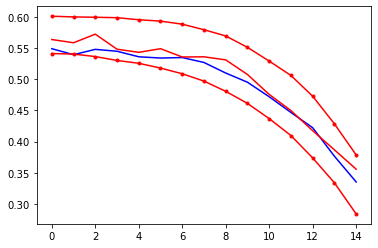

In [34]:
plot(trainX2[0],'b')
plot(trainX2[50000],'r')

plot(testInvivo2[8],'r.-')
plot(testInvivo2[50],'r.-')

In [35]:
def select_pred_result(pred,data,tag):
    pred_selt = []
    ind_selt = []
    
    for ii in range(len(pred)):
        if pred[ii] == tag:
#             print(ii)
#             print (data[ii].shape)
            pred_selt.append(data[ii])
            ind_selt.append(ii)
            
    pred_selt = array(pred_selt)
    ind_selt = array(ind_selt)
    
    return pred_selt, ind_selt

In [36]:
start_time = time.clock()
Invivo_pred0 = model.predict(testInvivo0)

Invivo_pred01 = zeros(Invivo_pred0.shape[0])

for ii in range(Invivo_pred0.shape[0]):
    Invivo_pred01[ii] = numpy.argmax(Invivo_pred0[ii])
    
selt_data2,ind_selt2 = select_pred_result(Invivo_pred01,testInvivo2,tag=1)
Invivo_pred1 = clf2.predict(selt_data2)

Invivo_pred2 = Invivo_pred01.copy()
Invivo_pred2[ind_selt2] = Invivo_pred1

# for ii in range(Invivo_pred0.shape[0]):
#     Invivo_pred0[ii] = Invivo_pred0[ii].round()
    
print (time.clock() - start_time, "seconds")

4.280088000000003 seconds


In [37]:
from sklearn import metrics
print('Step1: accuracy_score: %.3f' % (metrics.accuracy_score(testLabel2, Invivo_pred01)))

print('Step2: accuracy_score: %.3f' % (metrics.accuracy_score(testLabel2, Invivo_pred2)))


Step1: accuracy_score: 0.772
Step2: accuracy_score: 0.776


In [38]:
inds_01=where((Index!=2))[0]
print('Step1: accuracy_score: %.3f' % (metrics.accuracy_score(testLabel2[inds_01], Invivo_pred01[inds_01])))
print('Step2: accuracy_score: %.3f' % (metrics.accuracy_score(testLabel2[inds_01], Invivo_pred2[inds_01])))


Step1: accuracy_score: 0.757
Step2: accuracy_score: 0.767


In [39]:
Invivo_pred = Invivo_pred01
testLabel = testLabel2

In [40]:
from imblearn.metrics import sensitivity_specificity_support
sensitivity_specificity_support(testLabel, Invivo_pred, average='macro')

/Users/cbie1/opt/anaconda2/envs/python36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


(0.7572092039130579, 0.9071070227590136, None)

In [41]:
# confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

results = confusion_matrix(testLabel, Invivo_pred)

print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',accuracy_score(testLabel, Invivo_pred) )
print ('Report : ')
print (classification_report(testLabel, Invivo_pred))


Confusion Matrix :
[[ 89  15   0]
 [ 31  54   0]
 [  9  61 249]]
Accuracy Score : 0.7716535433070866
Report : 
              precision    recall  f1-score   support

         0.0       0.69      0.86      0.76       104
         1.0       0.42      0.64      0.50        85
         2.0       1.00      0.78      0.88       319

    accuracy                           0.77       508
   macro avg       0.70      0.76      0.71       508
weighted avg       0.84      0.77      0.79       508



In [42]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Pastel1):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    matrix = zeros(cm.shape)
    for ii in range(matrix.shape[0]):
        for jj in range(matrix.shape[1]):
            if ii == jj:
                matrix[ii, jj] = 0.08
            else:
                matrix[ii, jj] = 0.1


    plt.imshow(matrix, cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=15)
    plt.yticks(tick_marks, classes, rotation=45, fontsize=15)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        tag = "{:.1f}%".format(round(cm[i, j]*100,1))
#         tag = "{:d}%".format(int(round(cm[i, j]*100)))
        if i == j:
            plt.text(j, i, tag, fontsize=13, color='k', horizontalalignment="center")
        else:
            plt.text(j, i, tag, fontsize=13, color='k', horizontalalignment="center")
#         plt.text(j, i, tag, fontsize=13,
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=20)
    plt.xlabel('Predictive label',fontsize=20)

Normalized confusion matrix
[[0.86 0.14 0.  ]
 [0.36 0.64 0.  ]
 [0.03 0.19 0.78]]


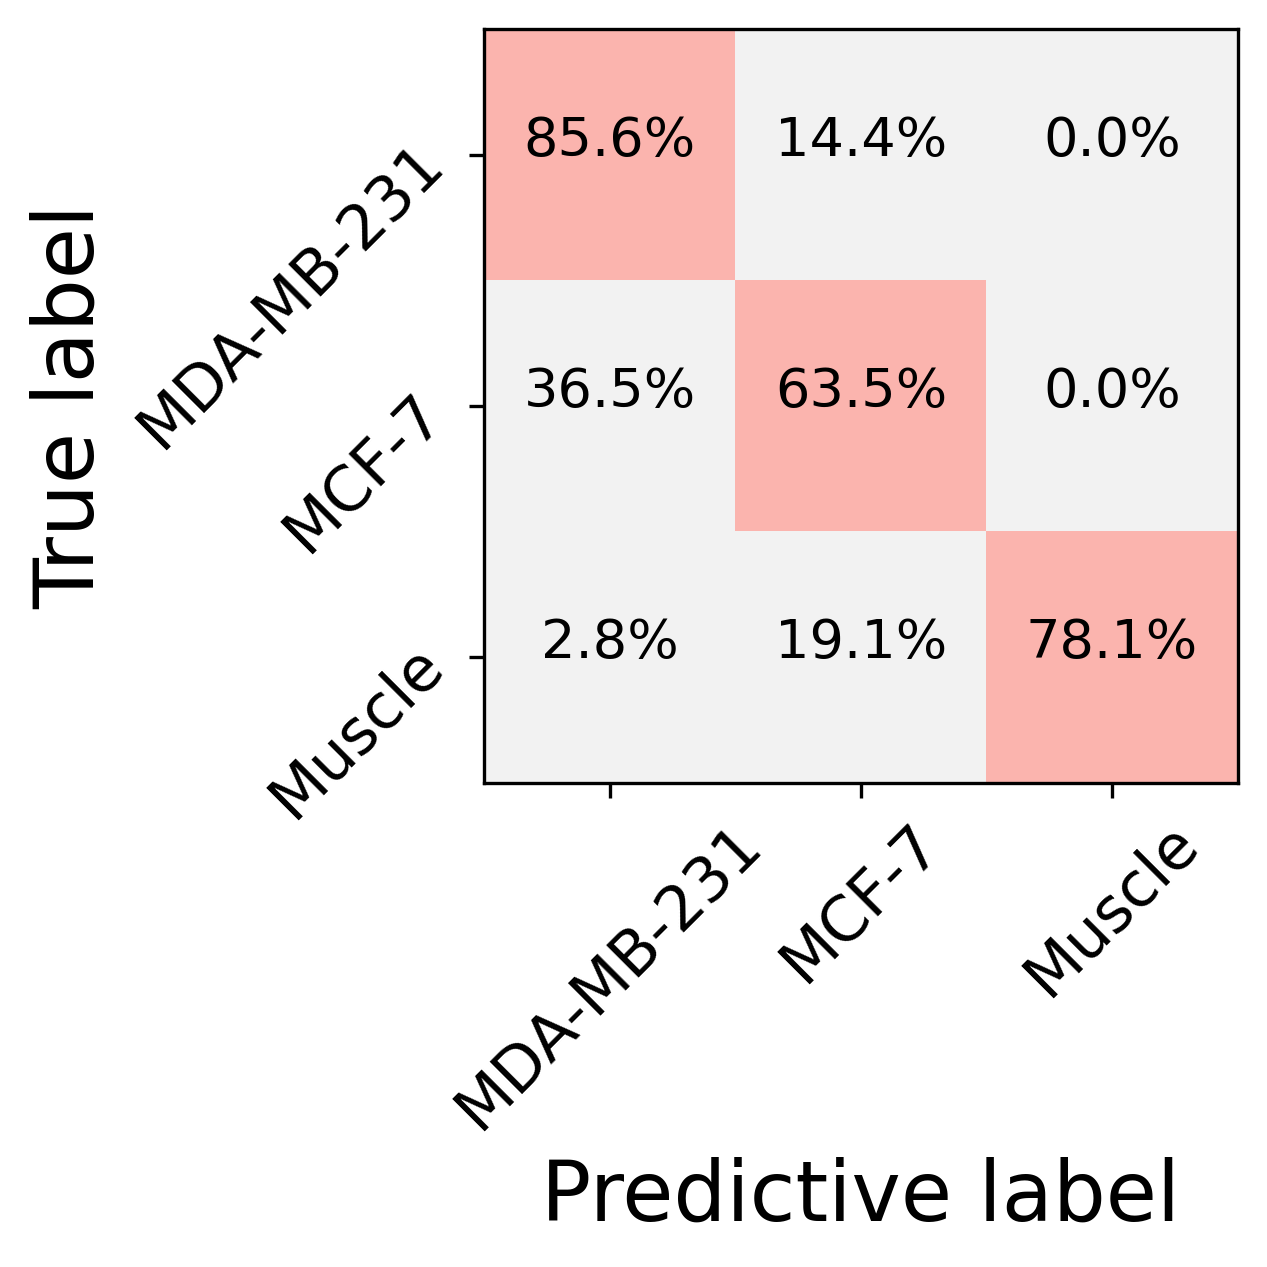

In [43]:
# Compute confusion matrix
import itertools
from sklearn.metrics import confusion_matrix

class_names = ['MDA-MB-231','MCF-7','Muscle']
cnf_matrix = confusion_matrix(testLabel, Invivo_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(dpi=300)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      normalize=True)
plt.show()

In [44]:
# save predicted results
numpy.savetxt(path2 + mouse+ '_pred_sep_knn_uneven_2uT_1.csv', Invivo_pred01, delimiter = ',')
numpy.savetxt(path2 + mouse+ '_pred_sep_knn_uneven_2uT_2.csv', Invivo_pred2, delimiter = ',')

# numpy.savetxt(path2 + mouse+ '_pred_sep_knn_2uT_2mm_1.csv', Invivo_pred0, delimiter = ',')
# numpy.savetxt(path2 + mouse+ '_pred_sep_knn_2uT_2mm_2.csv', Invivo_pred2, delimiter = ',')

In [45]:
y_score = model.predict_proba(testInvivo0)
# y_score = Invivo_pred0
y_test = testLabel0

y_score_new = zeros(y_score.shape)
for ii in range(y_score.shape[0]):
    for jj in range(y_score.shape[1]):
        y_score_new[ii,jj] = round(y_score[ii,jj],3)

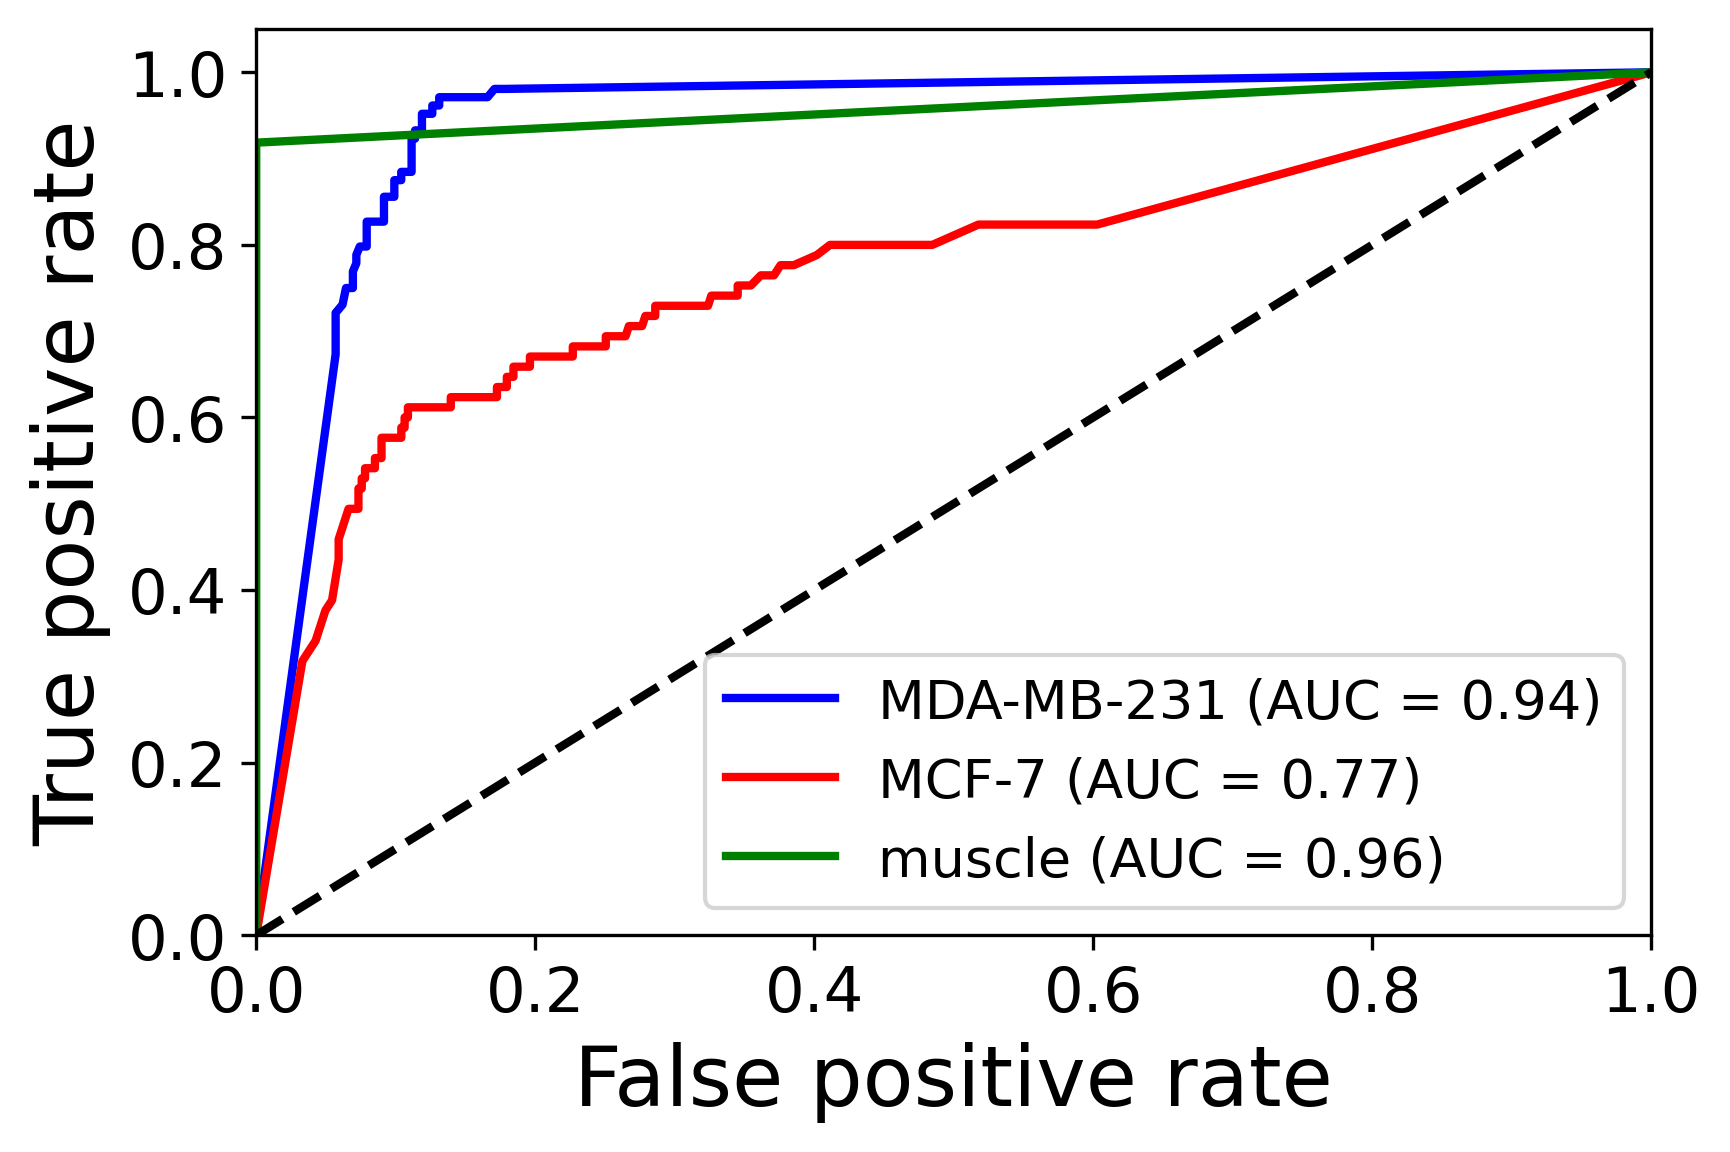

In [46]:
# y_score = model.predict_proba(testInvivo0)
# # y_score = Invivo_pred0
# y_test = testLabel0

import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2
n_classes = 3

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
thresholds = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], thresholds[i] = roc_curve(y_test[:, i], y_score_new[:, i],pos_label=1)
    roc_auc[i] = auc(fpr[i], tpr[i])


# Plot all ROC curves
plt.figure(1, dpi=300)

colors = cycle(['b', 'r', 'g'])
class_label=['MDA-MB-231', 'MCF-7','muscle']

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i],  color=color, lw=lw,
             label='{0} (AUC = {1:0.2f})'
             ''.format(class_label[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate',fontsize=20)
plt.ylabel('True positive rate',fontsize=20)
# plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right",fontsize=13)
plt.tick_params(labelsize=15)
plt.show()


 